# Master's thesis : Evolution of sarcasm detection by using Machine Learning techniques

### Managing imports

In [37]:
!pip install tensorflow transformers torch datasets hf_xet

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 39.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import torch
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm



## Dataset 1

#### Loading dataset 1

In [4]:
# Load the JSONL file (lines=True is key!)
df1 = pd.read_json('../Dataset/sarcasm_detection_shared_task_reddit_training.jsonl', lines=True)

# Map label: SARCASM -> 1, NOT_SARCASM -> 0
df1['label'] = df1['label'].replace({'SARCASM': 1, 'NOT_SARCASM': 0}).astype(int)

# Convert context list to string (join with ' ||| ')
df1['context'] = df1['context'].apply(lambda x: ' ||| '.join(x) if isinstance(x, list) else '')

# Save to CSV
df1.to_csv('../Dataset/sarcasm_detection_training_data.csv', index=False, columns=['label', 'response', 'context'])
df1


C:\Users\minht\AppData\Local\Temp\ipykernel_35380\4238227718.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['label'] = df1['label'].replace({'SARCASM': 1, 'NOT_SARCASM': 0}).astype(int)


,label,response,context
0,1,"Yeah I mean there's only one gender anyways, w...",LPT: If you're worried about hurting someone's...
1,1,"Sounds like you don't like science, you theist...",Promotional images for some guy's Facebook pag...
2,1,"Ofc play them in try mode, Blizzard were so ge...",My friends won't play Dota2; I won't play LoL;...
3,1,"I don't understand, Reddit told me that Hillar...",Poll: Convention boosts Clinton to 11-point le...
4,1,"yeh, they're the reigning triple premiers, why...",Wayne Ludbey: Jordan Lewis has the ultimate co...
...,...,...,...
4395,0,well you could've been adulting if you hadn't ...,8-9ft man found in ancient indian burial mound...
4396,0,Also they'll have to join the euro,Second Scottish independence referendum 'on th...
4397,0,plot: AI assists a cyborg in freelance investi...,Pinoy Cyborg by James Simmons ||| Mag-ingat sa...
4398,0,Some airlines proposed this but too much publi...,"The logic here is flawless! ||| No it isn't, f..."


#### Dataset 1 preparation


In [5]:
df1['input_text'] = df1['context'] + ' [SEP] ' + df1['response']

# Check the result
print(df1[['input_text', 'label']].head())


                                          input_text  label
0  LPT: If you're worried about hurting someone's...      1
1  Promotional images for some guy's Facebook pag...      1
2  My friends won't play Dota2; I won't play LoL;...      1
3  Poll: Convention boosts Clinton to 11-point le...      1
4  Wayne Ludbey: Jordan Lewis has the ultimate co...      1


#### Value count 

In [6]:
print(df1['label'].value_counts())

label
1    2200
0    2200
Name: count, dtype: int64


### SVM Classification

#### Splitting

In [ ]:
# Split
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(
    df1['input_text'], df1['label'],
    test_size=0.2, random_state=42, stratify=df1['label']
)

# Save train
train_df1 = pd.DataFrame({'input_text': X_train_SVM, 'label': y_train_SVM})
train_df1.to_csv("../Dataset/train_data.csv", index=False)

# Save test
test_df1 = pd.DataFrame({'input_text': X_test_SVM, 'label': y_test_SVM})
test_df1.to_csv("../Dataset/test_data.csv", index=False)

print("Train and test splits saved!")

Train and test splits saved!


#### Training

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train_SVM)

svm = SVC(class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_vec, y_train_SVM)

# Save the model and vectorizer for later use
joblib.dump(svm, "../Dataset/temp/svm_model.joblib")
joblib.dump(vectorizer, "../Dataset/temp/tfidf_vectorizer.joblib")

print("Training complete. Model and vectorizer saved.")

Training complete. Model and vectorizer saved.


#### Model evaluation

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       440
           1       0.59      0.58      0.59       440

    accuracy                           0.59       880
   macro avg       0.59      0.59      0.59       880
weighted avg       0.59      0.59      0.59       880



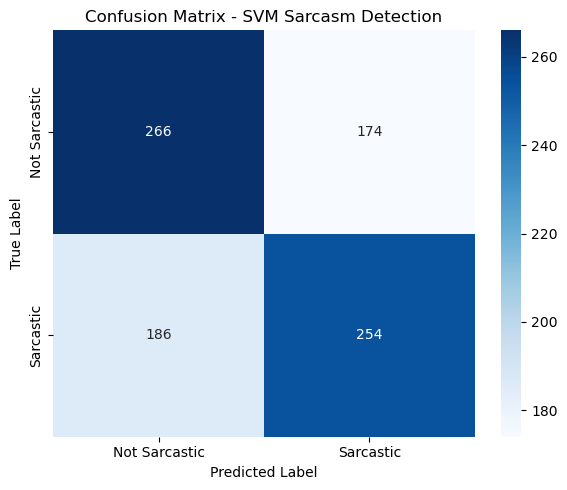

In [ ]:
# Load test data, model, and vectorizer
test_df1 = pd.read_csv("../Dataset/test_data.csv")
X_test_SVM = test_df1['input_text']
y_test_SVM = test_df1['label']

vectorizer = joblib.load("../Dataset/temp/tfidf_vectorizer.joblib")
svm = joblib.load("../Dataset/temp/svm_model.joblib")

# Transform test data and predict
X_test_vec_SVM = vectorizer.transform(X_test_SVM)
y_pred_SVM = svm.predict(X_test_vec_SVM)

# Evaluate
print("Classification Report:\n", classification_report(y_test_SVM, y_pred_SVM))

cm = confusion_matrix(y_test_SVM, y_pred_SVM)
labels = ['Not Sarcastic', 'Sarcastic']

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM Sarcasm Detection')
plt.tight_layout()
plt.show()

### LSTM 

#### Splitting 

In [ ]:
X_train_LSTM = train_df1['input_text']
y_train_LSTM = train_df1['label']
X_test_LSTM = test_df1['input_text']
y_test_LSTM = test_df1['label']

max_words = 10000   # Vocabulary size
max_len = 64        # Max sequence length (adjust as needed)

# Fit tokenizer on training data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_LSTM)

# Convert texts to sequences
X_train_seq_LSTM = tokenizer.texts_to_sequences(X_train_LSTM)
X_test_seq_LSTM = tokenizer.texts_to_sequences(X_test_LSTM)

# Pad sequences
X_train_pad_LSTM = pad_sequences(X_train_seq_LSTM, maxlen=max_len, padding='post', truncating='post')
X_test_pad_LSTM = pad_sequences(X_test_seq_LSTM, maxlen=max_len, padding='post', truncating='post')

#### Training

In [ ]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train the model
history = model.fit(
    X_train_pad_LSTM, y_train_LSTM,
    epochs=5,             # You can increase epochs if you want
    batch_size=32,
    validation_split=0.1  # Reserve part of train for validation
)


c:\Users\minht\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5132 - loss: 0.6936 - val_accuracy: 0.5455 - val_loss: 0.6917
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5092 - loss: 0.6934 - val_accuracy: 0.4915 - val_loss: 0.6929
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5434 - loss: 0.6816 - val_accuracy: 0.5483 - val_loss: 0.6906
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5893 - loss: 0.6272 - val_accuracy: 0.4915 - val_loss: 0.7123
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6574 - loss: 0.5675 - val_accuracy: 0.5341 - val_loss: 0.8203


#### Evaluation

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5197 - loss: 0.8359
Test Accuracy: 0.5136
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
               precision    recall  f1-score   support

Not Sarcastic       0.53      0.25      0.34       440
    Sarcastic       0.51      0.78      0.62       440

     accuracy                           0.51       880
    macro avg       0.52      0.51      0.48       880
 weighted avg       0.52      0.51      0.48       880



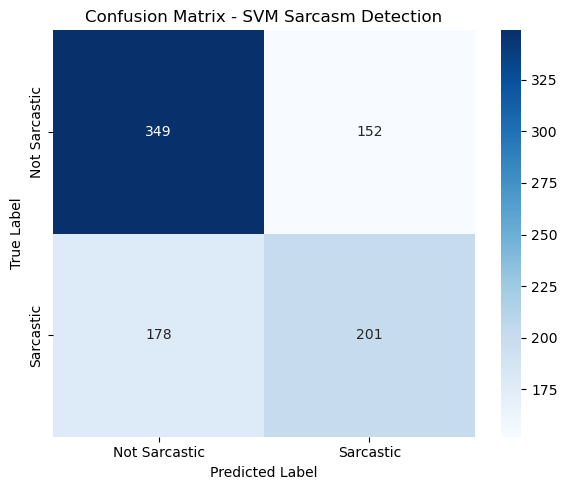

In [ ]:
loss, accuracy = model.evaluate(X_test_pad_LSTM, y_test_LSTM)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob_LSTM = model.predict(X_test_pad_LSTM)
y_pred_LSTM = (y_pred_prob_LSTM > 0.5).astype(int).flatten()

print(classification_report(y_test_LSTM, y_pred_LSTM, target_names=['Not Sarcastic', 'Sarcastic']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM Sarcasm Detection')
plt.tight_layout()
plt.show()
